#### Get Dataset from Simulations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mujoco_viewer
import cv2,os

import sys
sys.path.append('../')
from models.utils.util import  *
from models.env.manipulator_agent import ManipulatorAgent

In [2]:
xml_path = '../asset/ur5e/scene-w-ground-prism.xml'
MODE = 'window' ################### 'window' or 'offscreen'
env = ManipulatorAgent(rel_xml_path=xml_path,VERBOSE=False, MODE=MODE)
env.close_viewer()

MODE: window


In [3]:
# Place objects
object_names = ["obj_star_purple", "obj_star_red", "obj_star_blue", 
                "obj_triangle_purple", "obj_triangle_red", "obj_triangle_blue"]
obj_star_names = [body_name for body_name in env.body_names
            if body_name is not None and (body_name.startswith("obj_star"))]
obj_triangle_names = [body_name for body_name in env.body_names
            if body_name is not None and (body_name.startswith("obj_triangle"))]
n_obj = 3 # len(obj_names)
xyzs = sample_xyzs(
    n_sample=n_obj*2,x_range=[0.525,1.15],y_range=[-0.38,0.38],z_range=[0.74,0.85],min_dist=0.2,xy_margin=0.1)

for obj_idx, obj_star_name, obj_triangle_name in zip(range(n_obj), obj_star_names, obj_triangle_names):
    color_idx = obj_idx % 3
    star_jntadr = env.model.body(obj_star_name).jntadr[0]
    env.model.joint(star_jntadr).qpos0[:3] = xyzs[obj_idx, :]
    triangle_jntadr = env.model.body(obj_triangle_name).jntadr[0]
    env.model.joint(triangle_jntadr).qpos0[:3] = xyzs[obj_idx+n_obj, :]

# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0.395])
env.model.body('front_object_table').pos = np.array([0.38+0.6,0,0])
env.model.body('side_object_table').pos = np.array([-0.05,-0.80,0])
env.model.body('ur_base').pos = np.array([0.18,0,0.79])
env.model.body('ur_base').pos = np.array([0.18,0,0.8]) # robot base
for body_name in ['base_table','front_object_table','side_object_table']:
    geomadr = env.model.body(body_name).geomadr[0]
    env.model.geom(geomadr).rgba[3] = 1.0

print ("Ready.")

Ready.


#### Capture Scene

MODE: window
MODE: window


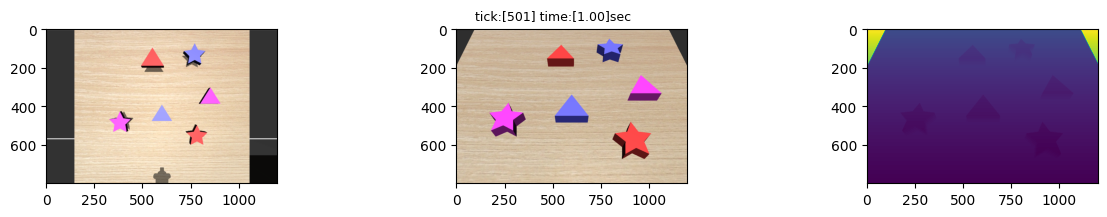

Done.


In [4]:
# Joint indices
rev_joint_names = ['shoulder_pan_joint','shoulder_lift_joint','elbow_joint',
                   'wrist_1_joint','wrist_2_joint','wrist_3_joint']
idxs_ur_fwd = env.get_idxs_fwd(joint_names=rev_joint_names)
idxs_ur_jac = env.get_idxs_jac(joint_names=rev_joint_names)
idxs_ur_step = env.get_idxs_step(joint_names=rev_joint_names)

init_pose = np.array([-1.571, -2.1916,  1.7089,  2.0533,  1.1000, -1.5706])
init_pose = np.array([-1.57077466, -2.32822577,  2.32735698,  1.57164833,  0.96625407, -1.57076883])
env.forward(q=init_pose,joint_idxs=idxs_ur_fwd)

# Place objects

object_names = ["obj_star_purple", "obj_star_red", "obj_star_blue", 
                "obj_triangle_purple", "obj_triangle_red", "obj_triangle_blue"]
obj_star_names = [body_name for body_name in env.body_names
            if body_name is not None and (body_name.startswith("obj_star"))]
obj_triangle_names = [body_name for body_name in env.body_names
            if body_name is not None and (body_name.startswith("obj_triangle"))]
n_obj = 3 # len(obj_names)
xyzs = sample_xyzs(
    n_sample=n_obj*2,x_range=[0.525,1.15],y_range=[-0.38,0.38],z_range=[0.74,0.85],min_dist=0.2,xy_margin=0.1)

for obj_idx, obj_star_name, obj_triangle_name in zip(range(n_obj), obj_star_names, obj_triangle_names):
    color_idx = obj_idx % 3
    star_jntadr = env.model.body(obj_star_name).jntadr[0]
    env.model.joint(star_jntadr).qpos0[:3] = xyzs[obj_idx, :]
    triangle_jntadr = env.model.body(obj_triangle_name).jntadr[0]
    env.model.joint(triangle_jntadr).qpos0[:3] = xyzs[obj_idx+n_obj, :]

env.reset()
env.forward(q=init_pose,joint_idxs=idxs_ur_fwd)
env.set_viewer()
env.update_viewer(azimuth=0,distance=0.5,elevation=-90,lookat=[0.8,0.0,1.2],
                VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                VIS_JOINT=False,jointlength=0.5,jointwidth=0.1,
                jointrgba=[0.2,0.6,0.8,0.6])

FIRST_FLAG = True
while env.is_viewer_alive():
    # Step
    env.step(ctrl=np.append(init_pose,1.0),ctrl_idxs=idxs_ur_step+[6])
    
    # Render
    if env.loop_every(HZ=1) and env.get_sim_time() >= 1.0:
        fig,axs = plt.subplots(1,3,figsize=(15,2))
        scene_img,rgb_img,depth_img = env.get_image_both_mode(body_name='ur_camera_center')
        axs[0].imshow(scene_img); axs[1].imshow(rgb_img); axs[2].imshow(depth_img)
        fig.suptitle('tick:[%d] time:[%.2f]sec'%(env.tick,env.get_sim_time()),fontsize=9)
        plt.subplots_adjust(wspace=0.2); plt.show()
        break

    # Clear flag
    FIRST_FLAG = False
env.close_viewer()
print ("Done.")

#### Move object with each preference objective: `Color, Shape, Stack`

In [5]:
def save_img(scene_img, rgb_img, img_idx, save_path):
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    print(save_path+f'scene_img_{img_idx}.png')
    plt.imsave(save_path+f'scene_img_{img_idx}.png',scene_img)
    plt.imsave(save_path+f'rgb_img_{img_idx}.png',rgb_img)

In [6]:
def random_sample_object(env):
    # Place objects
    obj_star_names = [body_name for body_name in env.body_names
                if body_name is not None and (body_name.startswith("obj_star"))]
    obj_triangle_names = [body_name for body_name in env.body_names
                if body_name is not None and (body_name.startswith("obj_triangle"))]
    n_obj = 3 # len(obj_names)
    xyzs_star = sample_xyzs(
        n_sample=n_obj,x_range=[0.525,1.05],y_range=[-0.38,0.08],z_range=[0.74,0.80],min_dist=0.2,xy_margin=0.1)
        # n_sample=n_obj,x_range=[0.725,0.725],y_range=[-0.15,-0.15],z_range=[0.74,1.00],min_dist=0.0,xy_margin=0.0)
    xyzs_triangle = sample_xyzs(
        n_sample=n_obj,x_range=[0.525,1.05],y_range=[-0.08,0.35],z_range=[0.74,0.80],min_dist=0.15,xy_margin=0.05)
        # n_sample=n_obj,x_range=[0.725,0.725],y_range=[0.15,0.15],z_range=[0.74,1.00],min_dist=0.0,xy_margin=0.0)

    for obj_idx, obj_star_name, obj_triangle_name in zip(range(n_obj), obj_star_names, obj_triangle_names):
        star_jntadr = env.model.body(obj_star_name).jntadr[0]
        env.model.joint(star_jntadr).qpos0[:3] = xyzs_star[obj_idx, :]
        triangle_jntadr = env.model.body(obj_triangle_name).jntadr[0]
        env.model.joint(triangle_jntadr).qpos0[:3] = xyzs_triangle[obj_idx, :]

In [7]:
def parse_color_shape(obj_name):
    """
        Parse color and shape from object name
    """
    parts = obj_name.split('_')
    return parts[2], parts[1]  # (color, shape)

def get_object_positions(env, object_names):
    positions = {}
    for obj in object_names:
        positions[obj] = env.get_p_body(obj)
    return positions

def calculate_distance(pos1, pos2):
    return np.linalg.norm(np.array(pos1) - np.array(pos2))

object_positions = get_object_positions(env, object_names)

max_distance = 0
max_pair = (None, None)
for star in [obj for obj in object_names if 'star' in obj]:
    for triangle in [obj for obj in object_names if 'triangle' in obj]:
        distance = calculate_distance(object_positions[star], object_positions[triangle])
        if distance > max_distance:
            max_distance = distance
            max_pair = (star, triangle)
max_pair

('obj_star_purple', 'obj_triangle_purple')

MODE: window
MODE: window


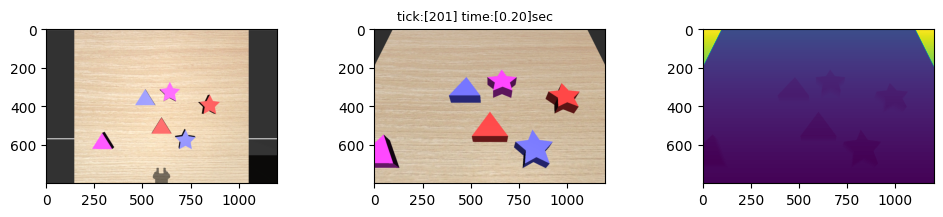

./prism/shape/1scene_img_0.png
Moved object `obj_star_purple` to ['0.697', '-0.242', '0.840']
move obj_star_purple to obj_star_red


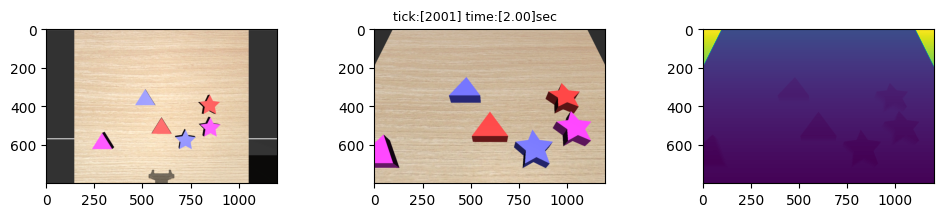

./prism/shape/1scene_img_1.png
Moved object `obj_star_blue` to ['0.832', '-0.111', '0.840']
move obj_star_blue to obj_star_red


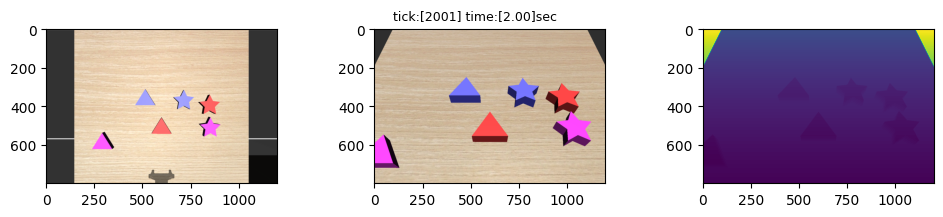

./prism/shape/1scene_img_2.png
Moved object `obj_triangle_red` to ['0.527', '0.396', '0.840']
move obj_triangle_red to obj_triangle_purple


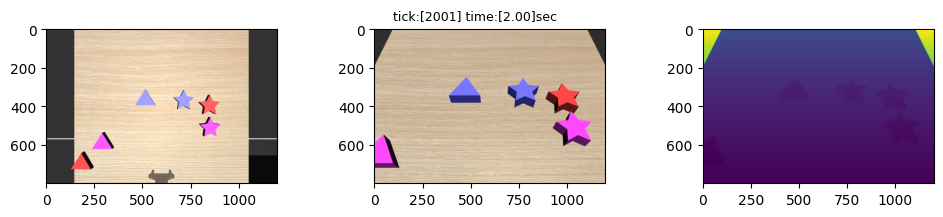

./prism/shape/1scene_img_3.png
Moved object `obj_triangle_blue` to ['0.584', '0.174', '0.840']
move obj_triangle_blue to obj_triangle_purple


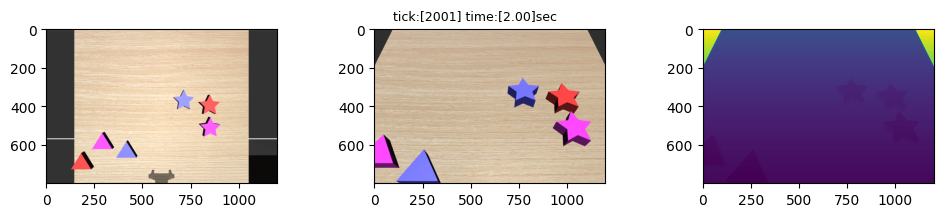

./prism/shape/1scene_img_4.png
MODE: window
MODE: window


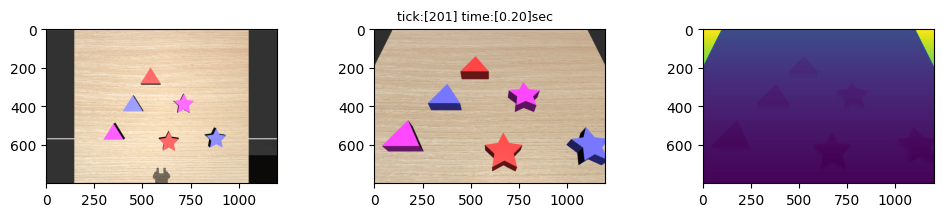

./prism/shape/2scene_img_0.png
Moved object `obj_triangle_red` to ['0.594', '0.108', '0.840']
move obj_triangle_red to obj_triangle_purple


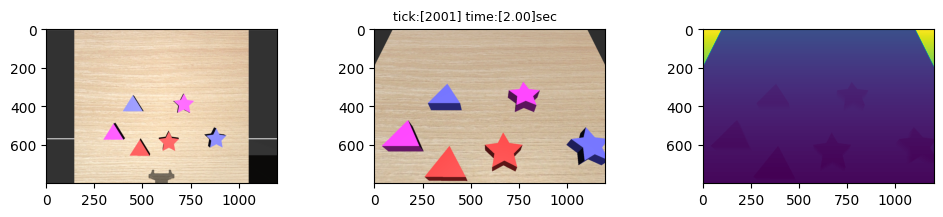

./prism/shape/2scene_img_1.png
Moved object `obj_triangle_blue` to ['0.514', '0.240', '0.840']
move obj_triangle_blue to obj_triangle_purple


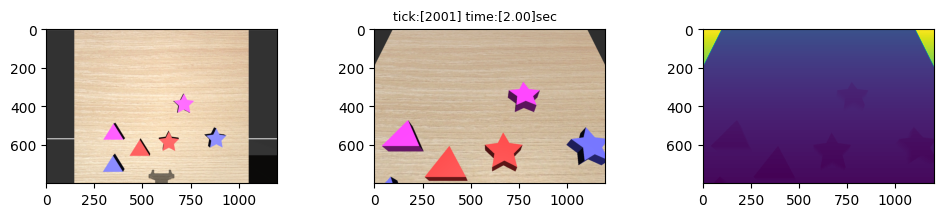

./prism/shape/2scene_img_2.png
Moved object `obj_star_purple` to ['0.713', '-0.354', '0.840']
move obj_star_purple to obj_star_blue


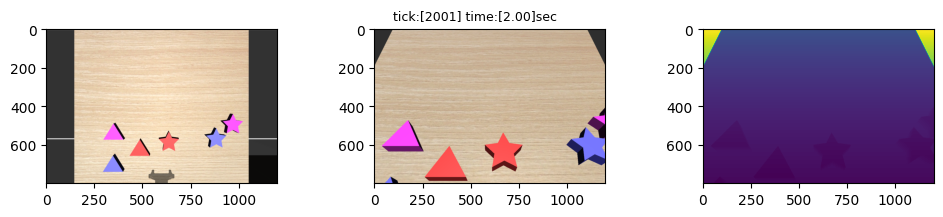

./prism/shape/2scene_img_3.png
Moved object `obj_star_red` to ['0.610', '-0.161', '0.840']
move obj_star_red to obj_star_blue


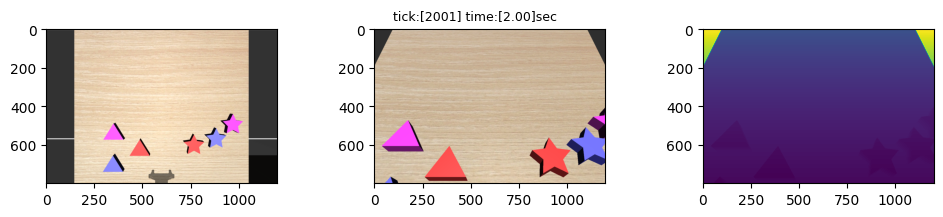

./prism/shape/2scene_img_4.png
MODE: window
MODE: window


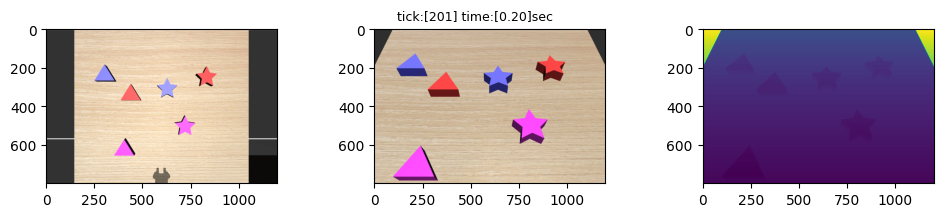

./prism/shape/3scene_img_0.png
Moved object `obj_triangle_red` to ['0.742', '0.148', '0.840']
move obj_triangle_red to obj_triangle_purple


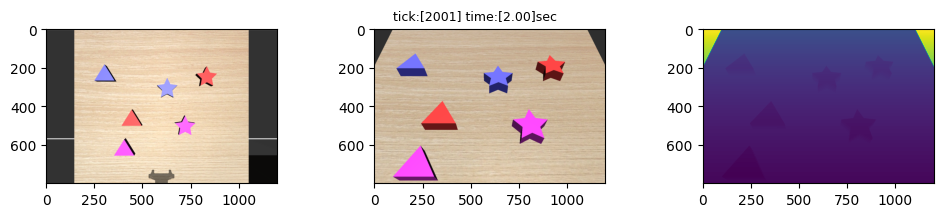

./prism/shape/3scene_img_1.png
Moved object `obj_triangle_blue` to ['0.508', '0.259', '0.840']
move obj_triangle_blue to obj_triangle_purple


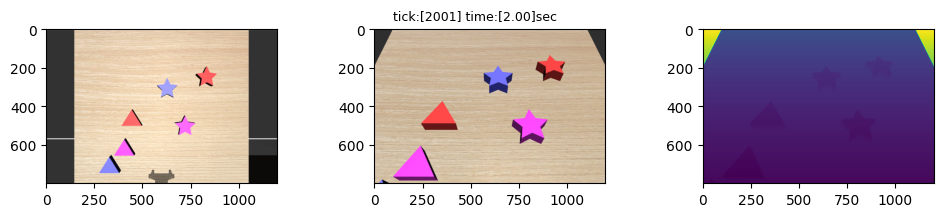

./prism/shape/3scene_img_2.png
Moved object `obj_star_purple` to ['0.850', '-0.294', '0.840']
move obj_star_purple to obj_star_red


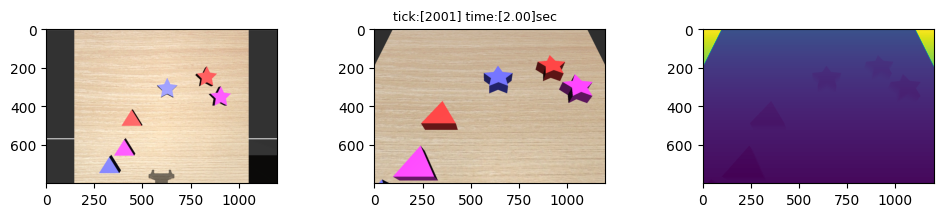

./prism/shape/3scene_img_3.png
Moved object `obj_star_blue` to ['0.862', '-0.129', '0.840']
move obj_star_blue to obj_star_red


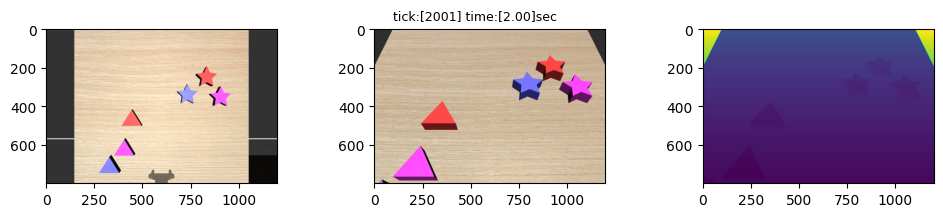

./prism/shape/3scene_img_4.png


In [11]:
for episode in range(3):
    preference_objective = ["color", "shape", "stack"]
    rand_idx = np.random.randint(0,3)
    rand_preference = preference_objective[rand_idx]
    # rand_preference = "color"
    rand_preference = "shape"
    # rand_preference = "stack"

    executed_action_list = []
    random_sample_object(env)
    env.set_viewer()
    env.reset()
    env.forward(q=init_pose,joint_idxs=idxs_ur_fwd)
    # Get images
    for _ in range(100): # for loop to place the object
        env.forward(q=init_pose,joint_idxs=idxs_ur_fwd)
        env.step(ctrl=np.append(init_pose,1.0),ctrl_idxs=idxs_ur_step+[6])
        if env.loop_every(HZ=20):
            env.render(render_every=1)
    fig,axs = plt.subplots(1,3,figsize=(12,2))
    scene_img,rgb_img,depth_img = env.get_image_both_mode(body_name='ur_camera_center')
    axs[0].imshow(scene_img); axs[1].imshow(rgb_img); axs[2].imshow(depth_img)
    fig.suptitle('tick:[%d] time:[%.2f]sec'%(env.tick,env.get_sim_time()),fontsize=9)
    plt.subplots_adjust(wspace=0.2); plt.show()
    env.set_object_configuration(object_names=object_names)
    save_img(scene_img, rgb_img, 0, f'./prism/{rand_preference}/{episode+1}')

    # Group items of the same color together
    if rand_preference == "color":
        # shuffle the order of the objects: ['red', 'blue', 'green']
        color_names = ['red', 'blue', 'green']
        np.random.shuffle(color_names)
        for interaction_idx, color in enumerate(color_names):
            star = next(obj for obj in object_names if f"star_{color}" in obj)
            triangle = next(obj for obj in object_names if f"triangle_{color}" in obj)
            triangle_position = env.get_body_position(triangle)
            env.stack_object(star, triangle_position)
            executed_action_list.append(f"env.stack_object({star}, {triangle_position})")
            print(f"stack {star} on {triangle}")
            env.reset()
            env.forward(q=init_pose,joint_idxs=idxs_ur_fwd)
            # Get images
            for _ in range(1000): # for loop to place the object
                env.forward(q=init_pose,joint_idxs=idxs_ur_fwd)
                env.step(ctrl=np.append(init_pose,1.0),ctrl_idxs=idxs_ur_step+[6])
                if env.loop_every(HZ=20):
                    env.render(render_every=1)
            fig,axs = plt.subplots(1,3,figsize=(12,2))
            scene_img,rgb_img,depth_img = env.get_image_both_mode(body_name='ur_camera_center')
            axs[0].imshow(scene_img); axs[1].imshow(rgb_img); axs[2].imshow(depth_img)
            fig.suptitle('tick:[%d] time:[%.2f]sec'%(env.tick,env.get_sim_time()),fontsize=9)
            plt.subplots_adjust(wspace=0.2); plt.show()
            env.set_object_configuration(object_names=object_names)
            save_img(scene_img, rgb_img, interaction_idx+1, f'./prism/{rand_preference}/{episode+1}')

    # Group items of the same shape together: Farthest pairs
    elif rand_preference == "shape":
        interaction_idx = 0
        shape_names = ['star', 'triangle']
        np.random.shuffle(shape_names)

        for shape_name in shape_names:
            same_shape_objects = [obj for obj in object_names if shape_name in obj]

            object_positions = get_object_positions(env, object_names)
            max_distance = 0
            farthest_pair = (None, None)
            for star in [obj for obj in object_names if 'star' in obj]:
                for triangle in [obj for obj in object_names if 'triangle' in obj]:
                    distance = calculate_distance(object_positions[star], object_positions[triangle])
                    if distance > max_distance:
                        max_distance = distance
                        farthest_pair = (star, triangle)

            for obj in same_shape_objects:
                if obj not in farthest_pair:
                    obj_color, obj_shape = parse_color_shape(obj)
                    if obj_shape == "star":
                        target = [obj for obj in farthest_pair if obj.startswith("obj_star")].pop()
                    elif obj_shape == "triangle":
                        target = [obj for obj in farthest_pair if obj.startswith("obj_triangle")].pop()

                    if shape_name ==  "star":
                        margin = 0.135
                    elif shape_name ==  "triangle":
                        margin = 0.165
                    executed_action_list.append(f"env.move_object({obj}, {target})")
                    env.move_object(obj, target, outer_margin=margin)
                    print(f"move {obj} to {target}")
                    env.reset()
                    env.forward(q=init_pose,joint_idxs=idxs_ur_fwd)
                    # Get images
                    for _ in range(1000): # for loop to place the object
                        env.forward(q=init_pose,joint_idxs=idxs_ur_fwd)
                        env.step(ctrl=np.append(init_pose,1.0),ctrl_idxs=idxs_ur_step+[6])
                        if env.loop_every(HZ=20):
                            env.render(render_every=1)
                    fig,axs = plt.subplots(1,3,figsize=(12,2))
                    scene_img,rgb_img,depth_img = env.get_image_both_mode(body_name='ur_camera_center')
                    axs[0].imshow(scene_img); axs[1].imshow(rgb_img); axs[2].imshow(depth_img)
                    fig.suptitle('tick:[%d] time:[%.2f]sec'%(env.tick,env.get_sim_time()),fontsize=9)
                    plt.subplots_adjust(wspace=0.2); plt.show()
                    env.set_object_configuration(object_names=object_names)
                    save_img(scene_img, rgb_img, interaction_idx+1, f'./prism/{rand_preference}/{episode+1}')
                    interaction_idx += 1

    # Stack items of the same shape together
    elif rand_preference == "stack":
        interaction_idx = 0
        shape_names = ['star', 'triangle']
        for shape_name in shape_names:
            # Filter objects by shape
            shape_objects = [obj for obj in object_names if shape_name in obj]
            if shape_objects:
                base_object = shape_objects[0]
                for obj in shape_objects[1:]:
                    object_position = env.get_body_position(base_object)
                    env.stack_object(obj, object_position)
                    executed_action_list.append(f"env.stack_object({obj}, {object_position})")
                    base_object = obj
                    env.reset()
                    env.forward(q=init_pose,joint_idxs=idxs_ur_fwd)
                    # Get images
                    for _ in range(200): # for loop to place the object
                        env.forward(q=init_pose,joint_idxs=idxs_ur_fwd)
                        env.step(ctrl=np.append(init_pose,1.0),ctrl_idxs=idxs_ur_step+[6])
                        if env.loop_every(HZ=20):
                            env.render(render_every=1)
                    fig,axs = plt.subplots(1,3,figsize=(12,2))
                    scene_img,rgb_img,depth_img = env.get_image_both_mode(body_name='ur_camera_center')
                    axs[0].imshow(scene_img); axs[1].imshow(rgb_img); axs[2].imshow(depth_img)
                    fig.suptitle('tick:[%d] time:[%.2f]sec'%(env.tick,env.get_sim_time()),fontsize=9)
                    plt.subplots_adjust(wspace=0.2); plt.show()
                    env.set_object_configuration(object_names=object_names)
                    save_img(scene_img, rgb_img, interaction_idx+1, f'./prism/{rand_preference}/{episode+1}')
                    interaction_idx += 1
    env.close_viewer()